# A demo of AdaSTEM model

Yangkang Chen<br>
Jan 11, 2024

This notebook is to provide a simple demonstration of how to use `stemflow` for `AdaSTEM` modeling.

For spherical indexing, see [SphereAdaSTEM demo](https://chenyangkang.github.io/stemflow/Examples/04.SphereAdaSTEM_demo.html).

We will explore a modeling task: Predict the abundance of [Mallard](https://en.wikipedia.org/wiki/Mallard) (a bird species) based on environmental variables. The data were requested from [eBird](https://ebird.org/home), a citizen science project for bird observation, and with some variable annotation.

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Download data

### Training/test data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

In [3]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


### Prediction set

Prediction set are used to feed into a trained AdaSTEM model and make prediction: at some location, at some day of year, given the environmental variables, how many Mallard individual do I expected to observe?

The prediction set will be loaded after the model is trained.

Download the prediction set from: https://figshare.com/articles/dataset/Predset_2020_csv/24124980

**Caveat: The file is about 700MB.**

## Get X and y

In [4]:
X = data.drop('count', axis=1)
y = data['count'].values


In [5]:
X.head()

,longitude,latitude,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


The features include:

- spatial coordinates:
  - `longitude` and `latitude` (used for indexing, not actual training)
    
- Temporal coordinate:
  - day of year (`DOY`): used for both indexing and training

- Sampling parameters: These are parameters quantifying how the observation was made
  - `duration_minutes`: How long the observation was conducted
  - Observation protocol: `Traveling`, `Stationary`, or `Area`
  -  `effort_distance_km`: how far have one traveled
  -  `number_observers`: How many observers are there in the group
  - `obsvr_species_count`: How many bird species have the birder observed in the past
  - `time_observation_started_minute_of_day`: When did the birder start birding

- Topological features:
  - Features of elevation: `elevation_mean`
  - Features of slope magnitude and direction: `slope_mean`, `eastness_mean`, `northness_mean`

- Bioclimate features:
  - Summaries of yearly temperature and precipitation: from `bio1` to `bio19`

- Land cover features:
  - Summaries of land cover, percentage of cover. For example, `closed_shrublands`,  `urban_and_built_up_lands`.
  - `entropy`: Entropy of land cover


As you can see, the environmental variables are almost static. However, dynamic features (e.g., daily temperature) is fully supported as input. See [Tips for data types](https://chenyangkang.github.io/stemflow/Tips/Tips_for_data_types.html) for details.
  
  
 

Now we can take a look at the target variable

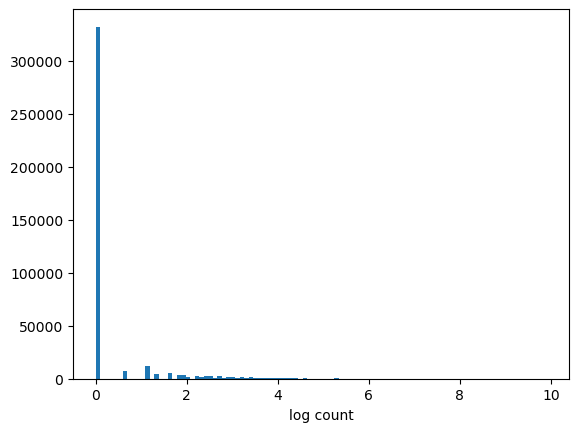

Percentage record with zero Mallard count: 83.09425%


In [6]:
plt.hist(np.log(y+1),bins=100)
plt.xlabel('log count')
plt.show()

zero_frac = np.sum(y==0)/len(y)
print(f'Percentage record with zero Mallard count: {zero_frac*100}%')


The target data is extremely zero-inflated. 83% checklists have not Mallard observation. This poses the necessity of using [hurdle model](https://chenyangkang.github.io/stemflow/Tips/Tips_for_different_tasks.html).

## First thing first: Spatiotemporal train test split

In [7]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                        Spatio1 = 'longitude',
                                                        Spatio2 = 'latitude',
                                                        Temporal1 = 'DOY',
                                                        Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                        random_state=42, test_size=0.3)


Here we used a spatiotemporal train-test-spit to split the data into different blocks. 

As shown, longitude and latitude are split into 50 bins separately, and DOY is split into 50 bins as well.

We then randomly select 30% of the spatiotemporal blocks as test data, and the rest as training data.

That is, if the data `X` have longitude ranging from `(-180, 180)`, latitude ranging from `(-90, 90)`, and whole year data `(1, 366)`, each block will approximately contain data of `7.2 longitude (about 800km)`, `3.6 latitude (about 400km)`, and `7 days`, which approximately catch the spatiotemporal scale of bird migration. These are rough estimates to get a sense of the scale. **Note: the actual geometry (in meter) of 1-degree longitude will change by the latitudinal positions. In that case, you may consider projecting your data to and equal-area coordinates. In our case, we believe that the bias induced by coordinate system is relatively low, considering the size of our grids (and this is the coordinate system used in the original AdaSTEM paper, although it is a apparent issue).**

The underlying interpretation is that: the generalization performance to adjacent (800km, 400km, 7days) block is [TEST RESULT]. As the bin count getting larger, the bin size get smaller, and your estimation becoming more radical and optimistic.

You can input any coordinate and set different bins as long as they match your model assumption.


## Train AdaSTEM hurdle model

In [8]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


We first import the models. Although some classes are not used, I imported them for complete showcase of function.

In [9]:
## "hurdle in Ada"
model = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),                                      # hurdel model for zero-inflated problem (e.g., count)
    save_gridding_plot = True,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=7,                # Only points covered by > 7 ensembles will be predicted
    grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
    grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=50,               # Each window will contain data of 50 DOY
    points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
    Spatio1='longitude',                    # The next three params define the name of 
    Spatio2='latitude',                     # spatial coordinates shown in the dataframe
    Temporal1='DOY',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    njobs=1
)

Here we used the `Hurdle` model as based model of `AdaSTEMRegressor`. For more discussion on modeling framework, see [Tips for different tasks](https://chenyangkang.github.io/stemflow/Tips/Tips_for_different_tasks.html) and [Model structure of AdaSTEM and Hurdle](https://chenyangkang.github.io/stemflow/Examples/05.Hurdle_in_ada_or_ada_in_hurdle.html).




During the "split-apply-combine" process, the data is first chunked into temporal windows by sliding window approach:
![sliding window approach](../assets/sliding_window.png)


Then, for each temporal window, we split the data into spatial grids:

We choose adaptive grid size between 5 unit and 25 unit because these parameters was used in the original [AdaSTEM paper](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1002/eap.2056). Large gird size will reduce the model performance (underfitting & over-extrapolation), and small gird size is likely overfitting to local condition. Likewise, we choose temporal window with size of 50 DOY and step of 25 DOY for that this timescale captures the onset and dynamics of migration. For more discussion on parameters please see [Optimizing stixel size](https://chenyangkang.github.io/stemflow/Examples/07.Optimizing_stixel_size.html). We ask that only stixels with more than 50 samples are trained, to avoid incomplete sampling during bird survey. This is also recommended in the AdaSTEM paper. For rare/hard-to-observe species, the value should be set larger.

You could also use 3D spherical indexing, which is unbiased towards poles: [SphereAdaSTEM demo](https://chenyangkang.github.io/stemflow/Examples/04.SphereAdaSTEM_demo.html).

We then fit the model by simply call:

In [10]:
# columns of X_train should only contain predictors and Spatio-temporal indicators (Spatio1, Spatio2, Temporal1)
model.fit(X_train.reset_index(drop=True), y_train, verbosity=1)


Training: 100%|██████████| 10/10 [09:28<00:00, 56.80s/it]


AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                                            l...
                                                          learning_rate=None,
                                                          max_bin=None,
                                                          max_cat_threshold=None,
                                                          max_cat_to_onehot=None,
                                                          max_delta_step=None,
                                                          max_depth=None,
                                                          max_leaves=None,
                                                          min_child_weight=None,
                                                          missing=nan,
                                                          monotone_constraints=None,
                                                          multi_strategy=None,
                                                          n_estimators=None,
                                                          n_jobs=1,
                                                          num_parallel_tree=None,
                                                          random_state=42, ...)),
                 save_gridding_plot=True, stixel_training_size_threshold=50,
                 temporal_step=25)

## Plot QuadTree ensembles

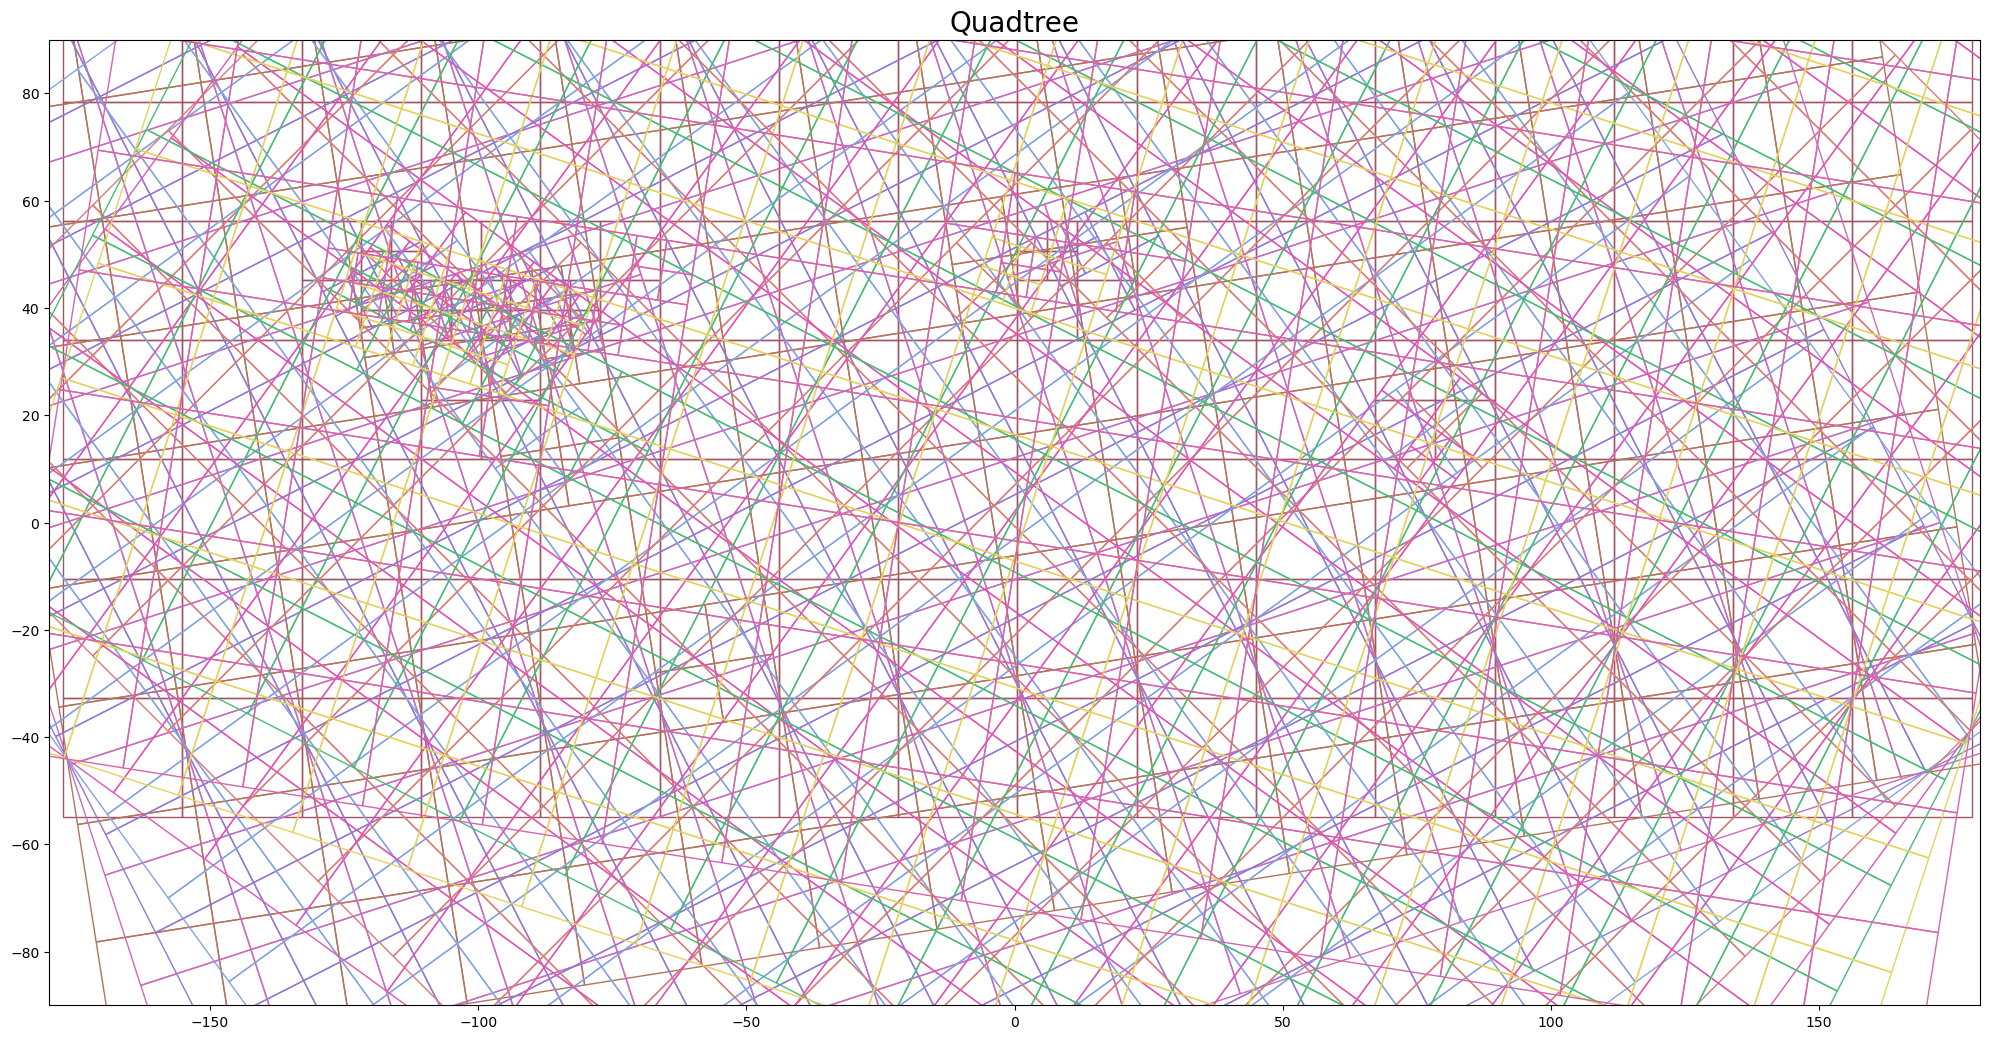

In [11]:
model.gridding_plot

This shows the 10 Quadtree ensembles we made. Region with higher data volume were split into smaller gird. The grid length is constrained between `(5, 25)` unit.

Take a look at the ensemble grids:

In [12]:
model.ensemble_df

,stixel_indexes,stixel_width,stixel_height,stixel_checklist_count,stixel_calibration_point(transformed),rotation,ensemble_index,DOY_start,DOY_end,unique_stixel_id,stixel_calibration_point_transformed_left_bound,stixel_calibration_point_transformed_lower_bound,stixel_calibration_point_transformed_right_bound,stixel_calibration_point_transformed_upper_bound,calibration_point_x_jitter,calibration_point_y_jitter
0,5,22.256832,22.256832,103,"(-271.409265, 317.171472)",0.0,0,-24.2,25.8,0_0_5,-271.409265,317.171472,-249.152433,339.428304,-94.030609,315.575834
1,15,22.256832,22.256832,407,"(-204.638768, 317.171472)",0.0,0,-24.2,25.8,0_0_15,-204.638768,317.171472,-182.381936,339.428304,-94.030609,315.575834
2,24,22.256832,22.256832,1892,"(-226.8956, 339.428304)",0.0,0,-24.2,25.8,0_0_24,-226.895600,339.428304,-204.638768,361.685136,-94.030609,315.575834
3,25,22.256832,22.256832,551,"(-226.8956, 361.685137)",0.0,0,-24.2,25.8,0_0_25,-226.895600,361.685137,-204.638768,383.941969,-94.030609,315.575834
4,26,11.128416,11.128416,208,"(-204.638768, 339.428304)",0.0,0,-24.2,25.8,0_0_26,-204.638768,339.428304,-193.510352,350.556720,-94.030609,315.575834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9614,127,11.273464,11.273464,83,"(40.088147, 413.973776)",81.0,9,344.6,394.6,15_9_127,40.088147,413.973776,51.361611,425.247240,9.597877,313.276531
9615,128,11.273464,11.273464,340,"(28.814682, 425.24724)",81.0,9,344.6,394.6,15_9_128,28.814682,425.247240,40.088146,436.520704,9.597877,313.276531
9616,129,11.273464,11.273464,659,"(28.814682, 436.520704)",81.0,9,344.6,394.6,15_9_129,28.814682,436.520704,40.088146,447.794168,9.597877,313.276531
9617,130,11.273464,11.273464,149,"(40.088147, 425.24724)",81.0,9,344.6,394.6,15_9_130,40.088147,425.247240,51.361611,436.520704,9.597877,313.276531


## Feature importances

After training the model, now we are interested in what features are important in bird abundance prediction

In [12]:
# Calcualte feature importance.
model.calculate_feature_importances()
# stixel-specific feature importance is saved in model.feature_importances_

The feature importances for each stixel are calculated:

In [13]:
model.feature_importances_.sample(5)

,stixel_index,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
8452,13_8_136,0.103101,0.011140,0.032374,0.000000,0.000000,0.009682,0.000296,0.012728,0.011251,0.036213,0.025602,0.011691,0.253207,0.100010,0.018680,0.013465,0.009551,0.016353,0.025531,0.026794,0.037057,0.005464,0.012232,0.007384,0.035718,0.024257,0.002774,0.012986,0.017419,0.008146,0.012483,0.023677,0.000000,0.000000,0.019937,0.000000,0.000000,0.000000,0.000000,0.009319,0.000000,0.000000,0.000000,0.000000,0.017287,0.016296,0.000000,0.015110,0.004782
8638,1_9_108,0.040851,0.066352,0.001394,0.000000,0.000000,0.008850,0.014455,0.116065,0.082297,0.084384,0.022175,0.016247,0.012383,0.019646,0.021033,0.010169,0.011747,0.007599,0.016879,0.020676,0.009831,0.011754,0.008538,0.007049,0.011858,0.011490,0.010244,0.008005,0.011292,0.010329,0.011123,0.010651,0.000000,0.129888,0.014936,0.000000,0.000000,0.000000,0.021292,0.017818,0.000000,0.008303,0.020491,0.000000,0.018002,0.034132,0.027193,0.006750,0.005831
8928,5_9_115,0.018109,0.012771,0.082735,0.046949,0.000000,0.012184,0.012650,0.064258,0.008282,0.014838,0.158901,0.047854,0.015449,0.021993,0.010081,0.010913,0.010976,0.018479,0.016146,0.013614,0.013786,0.008445,0.016728,0.008395,0.015641,0.012017,0.013353,0.012347,0.014525,0.014450,0.019323,0.069721,0.000000,0.011176,0.015732,0.012719,0.000000,0.000000,0.013750,0.017136,0.009035,0.000000,0.000000,0.025312,0.021246,0.035125,0.000000,0.012264,0.010593
6753,1_7_137,0.007963,0.011081,0.053554,0.000000,0.000000,0.019202,0.019945,0.041877,0.015085,0.020210,0.014907,0.009387,0.018266,0.020480,0.007345,0.013439,0.022612,0.017241,0.008994,0.009803,0.015553,0.014852,0.011502,0.015081,0.018444,0.014222,0.055888,0.009937,0.002375,0.028205,0.015232,0.009395,0.000000,0.038074,0.012419,0.018919,0.000000,0.012573,0.010371,0.006728,0.008851,0.212673,0.000000,0.009882,0.076046,0.015724,0.000706,0.014116,0.020842
6269,9_6_167,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408


The stixel index naming follows `{temporal_bin_index}_{ensemble_fold_index}_{grid_index}`. For example, `17_7_103` means the 17th temporal bin, 7th ensemble, and 103th gird. The digits shown are feature importance calculated by the `.feature_importances_` function of base model. Make sure your base model have one.

We can try to calculate the overall feature importance by average the ranking (or average the value directly). Notice: the assumption of this averaging is that the feature importance are homogeneous among different scales (that Quadtree generated), which may not be true.

In [14]:
top10_features = model.feature_importances_.iloc[:,1:].rank(axis=1).mean(axis=0).sort_values(ascending=False).head(10)
top10_features

slope_mean             33.268782
effort_distance_km     33.024435
elevation_mean         32.012243
duration_minutes       31.420600
eastness_mean          30.850943
northness_mean         30.686673
obsvr_species_count    30.342503
DOY                    29.829791
bio4                   29.765812
bio1                   29.200219
dtype: float64

Looks like `slope_mean`, `effort_distance_km`, and `elevation_mean` are the top 3 predictors of Mallard abundance across the sampled space and time. They indicate that sampling parameters and topography may play important role here.

Noteworthy, it is not saying that other features, like temperate, are not important. We split the data into spatiotemporal blocks, and these feature importances can only represent what is important for predicting the abundance `within` the stixel **(at the local level)**, not `across` them.


Now we want to visualize the feature importance by mapping them to spatiotemporal points. Our query points are constructed with 1-degree length and 7-days interval:

In [15]:
# make query points
Spatio_var1 = np.arange(-180, 180, 1)
Spatio_var2 = np.arange(-90, 90, 1)
Temporal_var1 = np.arange(1, 366, 7)
new_Spatio_var1, new_Spatio_var2, new_Temporal_var1 = np.meshgrid(Spatio_var1, Spatio_var2, Temporal_var1)

Sample_ST_df = pd.DataFrame(
    {
        model.Temporal1: new_Temporal_var1.flatten(),
        model.Spatio1: new_Spatio_var1.flatten(),
        model.Spatio2: new_Spatio_var2.flatten(),
    }
)

In [16]:
# Assign the feature importance to spatio-temporal points of interest
importances_by_points = model.assign_feature_importances_by_points(Sample_ST_df, verbosity=1, njobs=1)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [08:04<00:00, 48.45s/it]


In [17]:
importances_by_points.head()

,DOY,longitude,latitude,DOY_predictor,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
502069,1,-67,-64,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408
502070,8,-67,-64,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408
502071,15,-67,-64,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408
502072,22,-67,-64,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408
502073,29,-67,-64,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408,0.020408


In [18]:
# top 10 important variables
top_10_important_vars = importances_by_points[[
    i for i in importances_by_points.columns if not i in ['DOY','longitude','latitude']
    ]].mean().sort_values(ascending=False).head(10)

print(top_10_important_vars)


DOY_predictor          0.043400
duration_minutes       0.036215
effort_distance_km     0.032483
slope_mean             0.028832
eastness_mean          0.028681
elevation_mean         0.028424
bio4                   0.027756
obsvr_species_count    0.027289
northness_mean         0.026437
bio2                   0.026302
dtype: float64


We see that feature importances assigned to spatiotemporal points have similar but different top-ranking features. This is expected, for different methods are used.

## Ploting the feature importances by vairable names

We continue to visualize these feature important of dynamics:

In [19]:
from stemflow.utils.plot_gif import make_sample_gif

# make spatio-temporal GIF for top 3 variables
for var_ in top_10_important_vars.index[:3]:
    make_sample_gif(importances_by_points, f'./FTR_IPT_{var_}.gif',
                                col=var_, log_scale = False,
                                Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                                figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                                xtick_interval=20, ytick_interval=20,
                                lng_size = 360, lat_size = 180, dpi=100, fps=10)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!


In [20]:
top_10_important_vars.index[:3]

Index(['DOY_predictor', 'duration_minutes', 'effort_distance_km'], dtype='object')

The feature importance for vairable `DOY_predictor`:

![GIF of feature importance for vairable `DOY_predictor`](../assets/FTR_IPT_DOY_predictor.gif)

Focussing on North America (the large block on the left, longitude -160 to -40): The predictor `DOY` (day of year) seems to be a more important predictor during spring (30-150 DOY) than other time periods, which makes sense because spring migration is highly scheduled. And there is also higher importance in the middle migration flyway. This may indicate that there are more migrant Mallard population (since they follow the time heavily) in this regions.

## Plot uncertainty in training 

`stemflow` support calculating the variation of prediction across ensembles. It represent the uncertainty of making this prediction based on the surrounding information.

In [21]:
# calculate mean and standard deviation in abundance prediction
pred_mean, pred_std = model.predict(X_train.reset_index(drop=True), 
                                               return_std=True, verbosity=0, njobs=1)



Next, we can plot these uncertainties. We visualize them by first aggregate them to hexagons using h3pandas package (you may install it if you haven't):

In [22]:
# make error_df
error_df = X_train[['longitude', 'latitude']]
error_df.columns = ['lng', 'lat']
error_df['pred_std'] = pred_std
error_df['log_pred_std'] = np.log(pred_std+1)

# Aggregate error to hexagon
import h3pandas # You can also use other aggregation method if you don't want to install h3pandas
H_level = 3
error_df = error_df.h3.geo_to_h3(H_level)
error_df = error_df.reset_index(drop=False).groupby(f'h3_0{H_level}').mean()
error_df = error_df.h3.h3_to_geo_boundary()



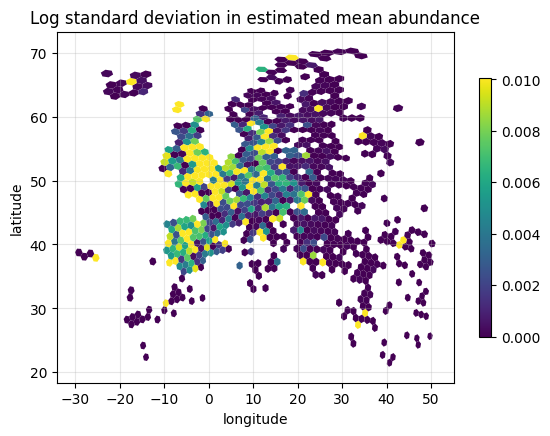

In [23]:
# plot mean uncertainty in hexagon
EU_error_df = error_df.query(
    '-30<=lng<=50 & 20<=lat<=80'
    )

EU_error_df.plot('log_pred_std', legend=True, legend_kwds={'shrink':0.7}, vmax = EU_error_df['log_pred_std'].quantile(0.9))

plt.grid(alpha=0.3)
plt.title('Log standard deviation in estimated mean abundance')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

We see a higher relative prediction uncertainty in western Europe than eastern Europe.

Likewise, you can also aggregate the `pred_std` based on temporal features:

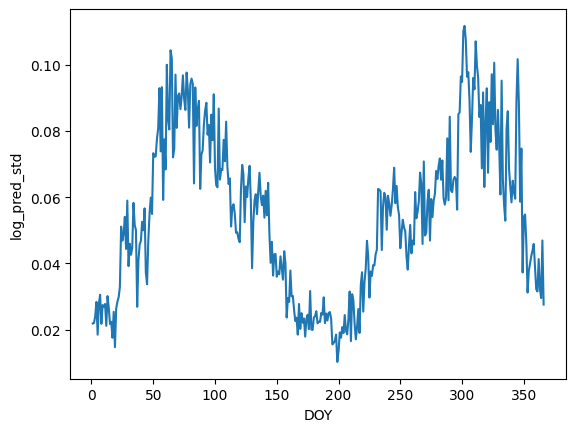

In [24]:
# make error_df
error_df = X_train[['longitude', 'latitude','DOY']]
error_df['log_pred_std'] = np.log(pred_std+1)
error_df.groupby('DOY')['log_pred_std'].mean().plot()
plt.ylabel('log_pred_std')
plt.show()


Interestingly, the prediction errors are the highest during spring and fall, when Mallards migrate, and lower during the summer and winter. It means the challenge of catching the abundance heterogeneity is larger during migration seasons.

## Save model

We use `pickle` to save the model:

In [25]:
with open('./01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)

To load the model, do:

In [26]:
with open('./01.demo_adastem_model.pkl','rb') as f:
    model = pickle.load(f)


Make sure you use the same version of `stemflow` for write and load models

## Evaluation

Now, we evaluate our overall model performance on the held-out test set:

In [27]:
pred = model.predict(X_test, verbosity=1)

predicting:   0%|          | 0/10 [00:00<?, ?it/s]

The samples not predictable are output as `np.nan`:

In [28]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 0.56%


AdaSTEM is relatively conservative compare to other models like Maxent, gradient boosting, or linear regression – It ameliorates the long-distance/long-range prediction problem. Consequently, there are 0.56% percent of test samples that cannot be predicted by our model, based on the configuration that they have to have 7 ensembles covered (set when we created the model). These samples are too far way from the "knowledge zone" that we trained on in terms of space and time.


We evaluate the performance using various metrics implemented in `AdaSTEM.eval_STEM_res` method:

In [29]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()

AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)

{'AUC': 0.7731797614916515,
 'kappa': 0.40502730744438487,
 'f1': 0.5331557728441907,
 'precision': 0.40912145136905764,
 'recall': 0.765118592596471,
 'average_precision': 0.35184105161199547,
 'Spearman_r': 0.4791697598274774,
 'Pearson_r': 0.21158338325998854,
 'R2': -0.00013321174037561612,
 'MAE': 4.074148226858181,
 'MSE': 1262.2164750538066,
 'poisson_deviance_explained': 0.1365089250997249}

The AUC reach 0.77, which is acceptable considering the quality of citizen science data. The recall is higher than precision, as expected. But R2 is low and MAE/MSE are high. This indicate that our model is good at classification, but the abundance output is not that good for downstream analysis.

## Compared to simple Hurdle model

What if we do not use AdaSTEM, instead, use a simple hurdle model with XGB base model?

In [30]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train.drop(['longitude','latitude'], axis=1), y_train)
pred2 = model2.predict(X_test.drop(['longitude','latitude'], axis=1))

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.614874754867373,
 'kappa': 0.3024531192247014,
 'f1': 0.3682267387656163,
 'precision': 0.643005991143527,
 'recall': 0.25798191984114544,
 'average_precision': 0.288061783500689,
 'Spearman_r': 0.3520394407206567,
 'Pearson_r': 0.15540117044791554,
 'R2': -0.11859108757092018,
 'MAE': 3.99918310458487,
 'MSE': 1405.505184365956,
 'poisson_deviance_explained': 0.06904965429918242}

The untuned naive hurdle model did not out perform the AdaSTEM model, in terms of both classification metrics and regression metrics, which proves the advantages of using AdaSTEM framework.

## Prediction

Now our model can show its full power: Making prediction

We first load the prediction set downloaded from https://figshare.com/articles/dataset/Predset_2020_csv/24124980 :

In [34]:
pred_set = pd.read_csv('./Predset_2020.csv')

For simplicity, we did not predict on the full set – Instead, we subsample the prediction set to 500 x 500 grids across the world, with one point per gird:

In [36]:
## reduce the prediction size
pred_set['lng_grid'] = np.digitize(
    pred_set.longitude,
    np.linspace(-180,180,500)
)

pred_set['lat_grid'] = np.digitize(
    pred_set.latitude,
    np.linspace(-90,90,500)
)

pred_set = pred_set.sample(frac=1, replace=False).groupby(['lng_grid','lat_grid']).first().reset_index(drop=True)
# pred_set = pred_set.drop(['lng_grid','lat_grid'], axis=1)


Then we can make our prediction. As mention before, the only dynamic feature in our model is `DOY`. To predict the abundance for each day, we only need to set the `DOY` to the target day. Additionally, we define the relative abundance prediction as 

"A birder (`number_observers=1`) <br>   who has observed 500 species (`obsvr_species_count=500`) in the past, <br> traveling 1km (`Traveling=1`; `effort_distance_km=1`) <br>  within one hour (`duration_minutes=60`) <br>    at 7:00 in the morning (`time_observation_started_minute_of_day=420`), <br>how many Mallard will they observe"


In [43]:
pred_df = []
for doy in tqdm(range(1,367)):
    pred_set['DOY'] = doy
    pred_set['duration_minutes'] = 60
    pred_set['Traveling'] = 1
    pred_set['Stationary'] = 0
    pred_set['Area'] = 0
    pred_set['effort_distance_km'] = 1
    pred_set['number_observers'] = 1
    pred_set['obsvr_species_count'] = 500
    pred_set['time_observation_started_minute_of_day'] = 420
    pred = model.predict(pred_set.fillna(-1), verbosity=0)
    
    pred_df.append(pd.DataFrame({
        'longitude':pred_set.longitude.values,
        'latitude':pred_set.latitude.values,
        'DOY':doy,
        'pred':np.array(pred).flatten()
    }))
    
    not_p = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
    # print(f'DOY {doy} Not predictable: {not_p*100}%')


  0%|          | 0/366 [00:00<?, ?it/s]

In [44]:
pred_df = pd.concat(pred_df, axis=0)
pred_df['pred'] = np.where(pred_df['pred']<0, 0, pred_df['pred'])

We set the prediction <0 to 0, because bird count cannot be negative.

Next, we plot our prediction on map:

In [45]:
from stemflow.utils.plot_gif import make_sample_gif
make_sample_gif(pred_df, './pred_gif_demo.gif',
                            col='pred', log_scale = True,
                            Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                            vmin=0.0001, vmax=pred_df['pred'].dropna().quantile(0.9),
                            cmap='viridis',
                            figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                            xtick_interval=20, ytick_interval=20,
                            lng_size = 360, lat_size = 180, dpi=100, fps=30)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.27

![Predicted Results Demo](../assets/pred_gif_demo.gif)

If you use more data for training and denser prediction set for visualization, it will probably look like (although it's for Barn Swallow):

![Predicted Results](../assets/pred_gif.gif)

## Calculate memory usage

Finally, we are interested in how many disk space & memory our model consumed. `stemflow` is typically memory costly, especially when data volume and ensembles go up – the memory usage may also go up linearly. We do not currently provide solution for memory optimization. We well come PR to work on that.

In [46]:
# Calculate memory usage
model_size_G = round(os.path.getsize('./01.demo_adastem_model.pkl')/1024/1024/1024, 2)
training_data_memory_G = round(X.memory_usage().sum()/1024/1024/1024, 2)

# Calculate model info
true_hurdle_model_count = np.sum([1 if isinstance(model.model_dict[i].classifier, XGBClassifier) else 0 for i in model.model_dict])
dummy_model_count = len(model.model_dict) - true_hurdle_model_count
true_hurdle_model_perc = round(true_hurdle_model_count/len(model.model_dict) * 100, 2)
dummy_model_perc = round(dummy_model_count/len(model.model_dict) * 100, 2)

In [47]:
print(f"""
      
      This AdaSTEM model have {len(model.model_dict)} trained based models in total.
      Among them, {dummy_model_count} ({dummy_model_perc}%) are dummy models that always predict one class (because the input data labels are homogeneous).
      Oppositely, {true_hurdle_model_count} ({true_hurdle_model_perc}%) are true hurdle models.
      
      The input data consume {training_data_memory_G} G memory.
      The model takes {model_size_G} G space on the disks.
      
""")



      
      This AdaSTEM model have 9597 trained based models in total.
      Among them, 2771 (28.87%) are dummy models that always predict one class (because the input data labels are homogeneous).
      Oppositely, 6826 (71.13%) are true hurdle models.
      
      The input data consume 0.15 G memory.
      The model takes 1.7 G space on the disks.
      



## Other potentially useful functions

### Obtaining spatial objects of stixels

Although for now `stemflow` doesn't have an internal function to obtain the spatial objects of stixel, one can realize it by:

In [11]:
from stemflow.utils.jitterrotation.jitterrotator import JitterRotator
from shapely.geometry import Polygon
import geopandas as gpd
# Remember to install shapely and geopandas if you haven't

# define a function
def geo_grid_geometry(line):
    old_x, old_y = JitterRotator.inverse_jitter_rotate(
        [line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_right_bound'], line['stixel_calibration_point_transformed_right_bound']],
        [line['stixel_calibration_point_transformed_lower_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_lower_bound']],
        line['rotation'],
        line['calibration_point_x_jitter'],
        line['calibration_point_y_jitter'],
    )

    polygon = Polygon(list(zip(old_x, old_y)))
    return polygon

# Make a geometry attribute for each stixel
model.ensemble_df['geometry'] = model.ensemble_df.apply(geo_grid_geometry, axis=1)
model.ensemble_df = gpd.GeoDataFrame(model.ensemble_df, geometry='geometry')

Which creates a spatial object for each stixel.

<Axes: >

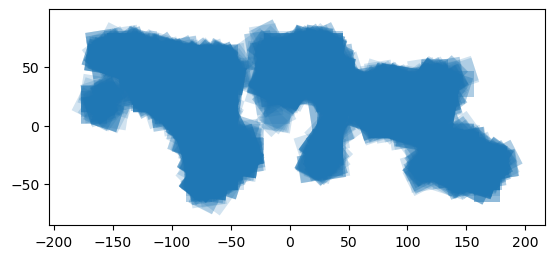

In [12]:
model.ensemble_df.plot(alpha=0.2)

The stixels will stack on the temporal dimension. You may want to pick only one time range (since the spatial splitting pattern will be the same for all temporal windows in one ensemble).

<Axes: >

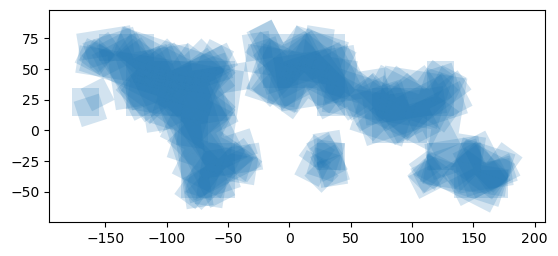

In [13]:
model.ensemble_df[
        (model.ensemble_df['DOY_start']>=90) & (model.ensemble_df['DOY_start']<120)
].plot(alpha=0.2)


Which will look less messy.

You may also want to add scatter points on top of this:

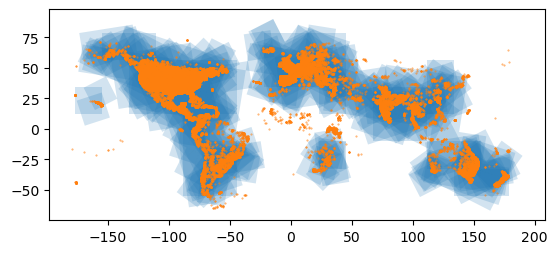

In [14]:
fig,ax = plt.subplots()

model.ensemble_df[
        (model.ensemble_df['DOY_start']>=90) & ((model.ensemble_df['DOY_start']<120))
].plot(alpha=0.2,ax=ax)

ax.scatter(
        X_train['longitude'],
        X_train['latitude'],
        c='tab:orange',s=0.2,alpha=0.7
)

plt.show()

Output to geojson: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_json.html

## Concluding mark

**Please open an issue if you have any question**

**Cheers!**


In [48]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2024-01-25T11:18:55.544088+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 1.0.9.4
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

